In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.impute import SimpleImputer

from tensorflow.keras.callbacks import EarlyStopping
import pickle
from tensorflow.keras.layers import Conv3D, MaxPool3D, Flatten, Dense, ReLU, AveragePooling3D, LeakyReLU, Add
from tensorflow.keras import regularizers

2024-04-19 14:22:28.517598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 14:22:28.561115: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.random.set_seed(1)
import random

import os
random.seed(1)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.impute import SimpleImputer

import os
from os import listdir
from os.path import isfile, join

#from keras.engine.topology import Layer
from keras.layers import Activation, Lambda, Conv1D, SpatialDropout1D, add
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, concatenate
from tensorflow.keras.models import Model
from sklearn.impute import KNNImputer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense, Input
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adadelta, Adam, SGD, Nadam
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [4]:
from keras import initializers

np.random.seed(16)
tf.random.set_seed(16)
from sklearn.preprocessing import OneHotEncoder


In [5]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/"
model_name = "cnn_1d_binaryClassifier.h5"
model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name
regressed_model_path = model_file_path + model_regressed

In [7]:
classes = 3

In [8]:
def fix_sim_geno_file(geno_file, classes, num_inds, num_snps):
    geno_df = pd.read_csv(geno_file,sep=",",index_col=0,header=0)
    print(geno_df.shape)
    
    geno_df = geno_df.drop(columns=['quantitative','binary'])
    
    # Compute the variance of each SNP
    snp_variances = geno_df.var()

    # Identify invariant SNPs (SNPs with zero variance)
    invariant_snps = snp_variances[snp_variances == 0].index
    print(invariant_snps)

    # Remove invariant SNPs from the dataset
    #geno_df = geno_df.drop(columns=invariant_snps)
    
    num_inds = geno_df.shape[0]
    num_snps = geno_df.shape[1]
    
    geno_np = geno_df.to_numpy()
    data_encoded = geno_np.reshape(num_inds, num_snps, 1)
    print(data_encoded.shape)
    
    list_ID = list(geno_df[0:250].index.values)
    
    return data_encoded[0:250], list_ID, geno_df[0:250]

In [9]:
def fix_geno_file(geno_file,classes, same_SNPs_list):
    geno_df = pd.read_csv(geno_file,sep="\t",index_col=2)
    geno_df = geno_df.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    print(geno_df.shape)
    
    geno_df_filtered = geno_df[geno_df.index.isin(same_SNPs_list)]
    
    dataframe_T = geno_df_filtered.T
    print(dataframe_T.shape)
    SNPs = len(dataframe_T.columns) #-1 # only drop one when its a revalued vcf file!!
    # Impute with KNN/ Simple
    SI = SimpleImputer(missing_values=9, strategy='most_frequent')
    #knn_imputer = KNNImputer(missing_values='9',n_neighbors=100, weights='uniform', metric='nan_euclidean')
    tmp = SI.fit_transform(dataframe_T)
    dataframe_T_imputed = pd.DataFrame(tmp, columns = dataframe_T.columns, index = dataframe_T.index)
    
    categories = [np.array([0, 1, 2])]*SNPs
    encoder = OneHotEncoder(categories=categories,sparse_output=False)
    data_encoded = encoder.fit_transform(dataframe_T_imputed.to_numpy())
    #print(data_encoded.shape)
    #data_encoded = data_encoded.toarray()
    data_encoded = data_encoded.reshape(-1, 1)
    list_ID = list(dataframe_T_imputed.index.values)
    data_encoded = data_encoded.reshape((len(list_ID),SNPs, classes))
    print(data_encoded.shape)
    
    #list_ID = list(dataframe_T_imputed.index.values) 
    return SNPs, list_ID, data_encoded



In [10]:
def fix_geno_file_noOHE(geno_file, same_SNPs_list):
    geno_df = pd.read_csv(geno_file,sep="\t",index_col=2)
    geno_df = geno_df.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    print(geno_df.shape)
    
    geno_df_filtered = geno_df[geno_df.index.isin(same_SNPs_list)]
    
    dataframe_T = geno_df_filtered.T
    print(dataframe_T.shape)
    SNPs = len(dataframe_T.columns) #-1 # only drop one when its a revalued vcf file!!
    # Impute with KNN/ Simple
    SI = SimpleImputer(missing_values=9, strategy='most_frequent')
    #knn_imputer = KNNImputer(missing_values='9',n_neighbors=100, weights='uniform', metric='nan_euclidean')
    tmp = SI.fit_transform(dataframe_T)
    dataframe_T_imputed = pd.DataFrame(tmp, columns = dataframe_T.columns, index = dataframe_T.index)
    np_T_imputed = dataframe_T_imputed.to_numpy()
    #categories = [np.array([0, 1, 2])]*SNPs
    #encoder = OneHotEncoder(categories=categories,sparse_output=False)
    #data_encoded = encoder.fit_transform(dataframe_T_imputed.to_numpy())
    #print(data_encoded.shape)
    #data_encoded = data_encoded.toarray()
    #data_encoded = data_encoded.reshape(-1, 1)
    list_ID = list(dataframe_T_imputed.index.values)
    data_encoded = np_T_imputed.reshape((len(list_ID),SNPs, 1))
    print(data_encoded.shape)
    
    #list_ID = list(dataframe_T_imputed.index.values) 
    return SNPs, list_ID, data_encoded, dataframe_T_imputed

In [11]:
def read_in_popStruc(popStruc_file,list_ID, num_comps):
    pop_struc = pd.read_csv(popStruc_file,sep=",", header=0, index_col=0)
    #pop_struc = pop_struc.drop(columns=['FIID'])
    pop_struc_subset = pop_struc.iloc[:, 0:num_comps]
    
    list_ID_pop = list(pop_struc_subset.index.values)
    merged_list = list(set(list_ID_pop) & set(list_ID))
    
    s = set(merged_list)
    temp3 = [x for x in list_ID if x not in s]
    
    #pop_struc = pop_struc[pop_struc['IID'].isin(list_ID)]
    pop_struc_subset = pop_struc_subset.loc[merged_list]
    #print(pop_struc[:10].head)
    print(pop_struc_subset.shape)
    return pop_struc_subset, temp3

In [12]:
def drop_missing(pids, list_ID, data):
    list_ID_new = list_ID
    print(data.shape)
    for i in pids:
        # Find index of patient ID to drop
        index_to_drop = list_ID.index(i)
        print(i," ",index_to_drop)

        # Drop the respective index from the numpy array
        data_new = np.delete(data, index_to_drop, axis=0)
        
        list_ID_new.remove(i)
        
        print(data_new.shape)
        print(len(list_ID_new))
        
    return data_new, list_ID_new

In [13]:
def reorder(pop_struc,list_ID):
    pop_struc = pop_struc.loc[lst]
    return pop_struc

In [14]:
def geno_cnn_big(inputLayer):
    # Input layer
    #input_layer = Input(shape=(46314, 1))

    # Convolutional layers (FOR BIGGER SNPS DIM)
    conv1 = Conv1D(filters=16, kernel_size=31, activation='relu',name="conv1G")((inputLayer[0]))
    batch_norm1 = BatchNormalization()(conv1)
    max_pooling1 = MaxPooling1D(pool_size=6,name="pool1G")(batch_norm1) #10

    conv2 = Conv1D(filters=32, kernel_size=15, activation='relu', kernel_regularizer=regularizers.l2(0.01),name="conv2G")(max_pooling1)
    batch_norm2 = BatchNormalization()(conv2)
    max_pooling2 = MaxPooling1D(pool_size=3,name="pool2G")(batch_norm2) #6

    #conv3 = Conv1D(filters=64, kernel_size=15, activation='relu',name="conv3G")(max_pooling2)
    #max_pooling3 = MaxPooling1D(pool_size=4, name="pool3G")(conv3)

    #conv4 = Conv1D(filters=128, kernel_size=15, name="conv4G")(max_pooling2)
    #batch_norm4 = BatchNormalization()(conv4)

    # Flatten layer
    flatten = Flatten()(max_pooling2)

    # Dense layers
    dense1 = Dense(512, activation='relu')(flatten)
    x = Dense(256, activation='relu')(dense1)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    return output_layer
    #return flatten

In [15]:
def geno_big_mlp(inputLayer):
    flatten = Flatten()

In [16]:
def geno_cnn_small(inputLayer):
    # Input layer
    #input_layer = Input(shape=(46314, 1))

    # Convolutional layers
    conv1 = Conv1D(filters=16, kernel_size=3, activation='relu',name="conv1G")((inputLayer[0]))
    batch_norm1 = BatchNormalization()(conv1)
    max_pooling1 = MaxPooling1D(pool_size=4,name="pool1G")(batch_norm1)

    conv2 = Conv1D(filters=32, kernel_size=3, activation='relu',name="conv2G")(max_pooling1)
    batch_norm2 = BatchNormalization()(conv2)
    max_pooling2 = MaxPooling1D(pool_size=3,name="pool2G")(batch_norm2)


    # Flatten layer
    flatten = Flatten()(max_pooling2)

    # Upsampling
    reshaped = Reshape((-1, 1))(flatten)
    upsampled = UpSampling1D(size=2)(reshaped)
    flatten = Flatten(name="flattenUpsample")(upsampled)

    # Dense layers
    dense1 = Dense(28, activation='relu')(flatten)
    #dropped = Dropout(.2)(dense1)
    output_layer = Dense(1, activation='sigmoid')(dense1)
    return output_layer

In [17]:
def compile_model(SNPs,classes):
    opt = Adam(lr=0.001)#,decay=1e-6)
    
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    
    inputA = Input(shape=(SNPs,classes),name="InputA")

    y = geno_cnn_big([inputA])

    model = Model(inputs=[inputA], outputs=[y])
    model.summary()
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return model

In [18]:
def scheduler(epoch, lr):
    #return lr * tf.math.exp(-0.1)
    decay_rate = 0.1
    decay_step = 10  # adjust as needed
    return lr * tf.math.exp(-decay_rate * epoch / decay_step)

In [19]:
def intermediate_model(layer, model):
    layer_output = model.get_layer(layer).output
    model = tf.keras.models.Model(inputs=model.input, outputs=layer_output)
    model.summary()
    return model

In [20]:
def get_outputs(model,data):
    features = model.predict(data)
    print(features.shape)
    return features

In [21]:
def binary_predictor_model(flatten_feature_size):
    # Binary Predictor Model
    input_layer_bp = layers.Input(shape=(flatten_feature_size, 1))  
    flatten = Flatten()(input_layer_bp)
    #dense5 = layers.Dense(600, activation='relu')(input_layer_bp)
    #dense6 = layers.Dense(512,activation='relu')(input_layer_bp)
    #dense7 = layers.Dense(256,activation='relu')(dense6)
    #max_pooling = layers.MaxPooling1D(pool_size=6)(dense6)
    
    
    # Dense layers
    x = Dense(512, activation='relu')(flatten)
    x = Dense(256, activation='relu')(x)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    #output_layer_bp = layers.Dense(1, activation='sigmoid')(dense7)


    binary_predictor_model = Model(input_layer_bp, output_layer, name="binary_predictor")
    binary_predictor_model.summary()
    
    opt = Adam(lr=0.00001)#,decay=1e-6)
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    binary_predictor_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return binary_predictor_model

In [22]:
def binary_predictor_model_noOHE(flatten_feature_size):
    # Binary Predictor Model
    input_layer_bp = layers.Input(shape=(flatten_feature_size))  
    #flatten = Flatten()(input_layer_bp)
    #dense5 = layers.Dense(600, activation='relu')(input_layer_bp)
    #dense6 = layers.Dense(512,activation='relu')(input_layer_bp)
    #dense7 = layers.Dense(256,activation='relu')(dense6)
    #max_pooling = layers.MaxPooling1D(pool_size=6)(dense6)
    
    
    # Dense layers
    #x = Dense(1024, activation='relu')(input_layer_bp)
    #x = Dropout(.2)(x)
    x = Dense(512, activation='relu')(input_layer_bp)
    x = Dense(256, activation='relu')(x)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    #output_layer_bp = layers.Dense(1, activation='sigmoid')(dense7)


    binary_predictor_model = Model(input_layer_bp, output_layer, name="binary_predictor")
    binary_predictor_model.summary()
    
    opt = Adam(lr=0.0001)#,decay=1e-6)
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    binary_predictor_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return binary_predictor_model

In [23]:
# def drop_index(PIDs_to_drop, list_ID, geno_df):
#     for i in PIDs_to_drop:
#         index_to_drop = list_ID.index(PID)
#         geno_df = np.delete(geno_df, index_to_drop, axis=0)
#     print("New Geno Shape: ", geno_df.shape)
#     return geno_df

In [24]:
def convert_preds(test_data, model):
    predictions = model.predict(test_data)
    predictions[predictions < 0.5] = 0
    predictions[predictions > 0.5] = 1
    print(predictions)
    return predictions

In [25]:
def my_confusion_matrix(y_test, predictions):

    accuracy = accuracy_score(y_test, predictions)
    confusion_mat = confusion_matrix(y_test, predictions)
    classification_rep = classification_report(y_test, predictions)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    print("Classification Report:\n", classification_rep)

In [26]:
def generate_labels(list_ids_cases, list_ids_controls):
    labels_cases = np.ones(len(list_ids_cases))
    labels_controls = np.zeros(len(list_ids_controls))
    return np.concatenate((labels_cases, labels_controls))


In [27]:
def split_data(list_ids_cases, list_ids_controls, data_cases, data_controls, test_size=0.3, valid_size=0.5, random_state=None):
    # Generate labels
    labels = generate_labels(list_ids_cases, list_ids_controls)
    
    # Combine cases and controls data
    X_combined = np.concatenate((data_cases, data_controls), axis=0)
    list_ids_combined = list_ids_cases + list_ids_controls
    print(len(list_ids_combined))
    
    # Splitting into train, test, and validation sets
    X_train, X_tmp, y_train, y_tmp, ids_train, ids_tmp = train_test_split(X_combined, labels, list_ids_combined, test_size=test_size, random_state=random_state, shuffle=True, stratify=labels)
    print(X_train.shape)
    X_test, X_valid, y_test, y_valid, ids_test, ids_valid = train_test_split(X_tmp, y_tmp, ids_tmp, test_size=valid_size, random_state=random_state, shuffle=True, stratify=y_tmp)
    print(X_test.shape)
    
    return X_train, X_test, X_valid, y_train, y_test, y_valid, ids_train, ids_test, ids_valid

In [28]:
def get_SNPs_merge(geno_file_1,geno_file_0):
    geno_df_1 = pd.read_csv(geno_file_1,sep="\t",index_col=2)
    geno_df_1 = geno_df_1.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    list_1 = list(geno_df_1.index.values)
    
    
    geno_df_0 = pd.read_csv(geno_file_0,sep="\t",index_col=2)
    geno_df_0 = geno_df_0.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    list_0 = list(geno_df_0.index.values)
    
    join_snps = list(set(list_0).intersection(list_1))
    
    return join_snps
    
    

In [29]:
def split_popStruc(ids_train, ids_test, ids_valid, pop_struc_1,pop_struc_0):
    frames = [pop_struc_1, pop_struc_0]
    result = pd.concat(frames)
    #popStruc_combined = np.concatenate((pop_struc_0,pop_struc_1),axis=0)
    
    train_pop_struc = result.loc[ids_train]
    test_pop_struc = result.loc[ids_test]
    valid_pop_struc = result.loc[ids_valid]
    
    return train_pop_struc,test_pop_struc,valid_pop_struc
    

In [30]:
def save_resids(data,ids,filename):
    resid_train = pd.DataFrame(data, index=ids)
    resid_train.to_csv(filename, index_label='ID')
    print("Saved: ",filename)

In [31]:
def save_split(data, ids, labels, filename):
    # Create DataFrame for residuals data
    #snps = pd.DataFrame(data, index=ids, columns=['Residuals'])

    # Create DataFrame for additional array data
    additional_df = pd.DataFrame({'label': labels}, index=ids)

    # Concatenate DataFrames along columns
    #merged_df = pd.concat([snps, additional_df], axis=1)

    # Save merged DataFrame to CSV
    additional_df.to_csv(filename, index_label='ID')

    print("Saved:", filename)

In [32]:
def plot_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    # Plotting the training and validation loss
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [33]:
# Define a function to get the gradients of the output with respect to the input
@tf.function
def get_gradients(model, inputs):
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(inputs)
        tape.watch(inputs)
        predictions = model(inputs)
    grads = tape.gradient(predictions, inputs)
    return grads

# Define a function to calculate Grad-CAM for a 1D input vector
def calculate_grad_cam_1d(model, inputs, class_idx):
    grads = get_gradients(model, inputs)
    pooled_grads = tf.reduce_mean(grads, axis=0)
    cam = pooled_grads * inputs
    return cam.numpy()

In [34]:
def plot_gradCam(test_data_features,y_test,sample_id, loaded_model):
    # Prepare a sample input (adjust as needed)
    sample_input = test_data_features[sample_id:sample_id+1].astype(np.float32)

    # Choose a class index for which you want to compute Grad-CAM (0 or 1 for binary classification)
    class_index = y_test[sample_id:sample_id+1]
    print(class_index)

    # Compute Grad-CAM for the 1D input vector
    grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)


    # Visualize the Grad-CAM heatmap (1D signal)
    plt.figure(figsize=(10, 3))
    plt.plot(abs(grad_cam[0]))
    #plt.title('Grad-CAM Heatmap (1D Signal)')
    plt.xlabel('Variant Position')
    plt.ylabel('|Grad-CAM Value|')
    plt.show()

    print(sample_input.shape)

    print(grad_cam.shape)  
    print(grad_cam)        
    
    return grad_cam

In [35]:
def norm(data):
    return (data)/(max(data)-min(data))

In [36]:
def plot_gradCam_ind_overlay(test_data_features1, test_data_features2, y_test, sample_id, loaded_model1, loaded_model2):
    # Prepare sample inputs for both versions (adjust as needed)
    sample_input1 = test_data_features1[sample_id:sample_id+1].astype(np.float32)
    sample_input2 = test_data_features2[sample_id:sample_id+1].astype(np.float32)

    # Choose a class index for which you want to compute Grad-CAM (0 or 1 for binary classification)
    class_index = y_test[sample_id:sample_id+1]

    # Compute Grad-CAM for the 1D input vector for both models and versions
    grad_cam1 = calculate_grad_cam_1d(loaded_model1, sample_input1, class_index)
    grad_cam2 = calculate_grad_cam_1d(loaded_model2, sample_input2, class_index)

    # Visualize the Grad-CAM heatmaps (1D signals) from both models and versions
    plt.figure(figsize=(10, 6))
    plt.plot(norm(abs(grad_cam1[0])), label='Non-regressed input')
    plt.plot(norm(abs(grad_cam2[0])), label='Regressed input')
    plt.xlabel('Variant Position')
    plt.ylabel('|Grad-CAM Value|')
    plt.legend()
    plt.show()

    return grad_cam1, grad_cam2


In [37]:
def plot_gradCam_average(test_data_features, y_test, label, loaded_model, output_to_flatten = False):
    # Filter samples based on the label
    indices = np.where(y_test == label)[0]
    if len(indices) == 0:
        print(f"No samples found with label {label}")
        return

    # Prepare the input data for the selected samples
    #sample_inputs = test_data_features[indices].astype(np.float32)
    #print(sample_inputs.shape)

    # Compute Grad-CAM for each input sample
    grad_cams = []
    if not output_to_flatten:
        for index in indices:
            sample_input = test_data_features[index:index+1].astype(np.float32)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)
            grad_cams.append(grad_cam)
    else:
        sample_inputs = test_data_features[indices].astype(np.float32)
        #print(sample_inputs.shape)
        
        for sample_input in sample_inputs:
            #print(sample_input.shape)
            reshaped_sample = sample_input.reshape(1, -1)
            #print(reshaped_sample.shape)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, reshaped_sample, class_index)
            grad_cams.append(grad_cam)

    # Average the Grad-CAM values over all samples
    avg_grad_cam = np.mean(grad_cams, axis=0)

    # Visualize the averaged Grad-CAM heatmap (1D signal)
    plt.figure(figsize=(10, 3))
    plt.plot(avg_grad_cam[0])
    plt.title(f'Averaged Grad-CAM Heatmap for Label {label} (1D Signal)')
    plt.xlabel('Input Position')
    plt.ylabel('Average Grad-CAM Value')
    plt.show()

    return avg_grad_cam


In [38]:
def plot_gradCam_average_manPlot(test_data_features, y_test, label, loaded_model, output_to_flatten = False):
    # Filter samples based on the label
    indices = np.where(y_test == label)[0]
    if len(indices) == 0:
        print(f"No samples found with label {label}")
        return

    # Prepare the input data for the selected samples
    #sample_inputs = test_data_features[indices].astype(np.float32)
    #print(sample_inputs.shape)

    # Compute Grad-CAM for each input sample
    grad_cams = []
    if not output_to_flatten:
        for index in indices:
            sample_input = test_data_features[index:index+1].astype(np.float32)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)
            grad_cams.append(grad_cam)
    else:
        sample_inputs = test_data_features[indices].astype(np.float32)
        #print(sample_inputs.shape)
        
        for sample_input in sample_inputs:
            #print(sample_input.shape)
            reshaped_sample = sample_input.reshape(1, -1)
            #print(reshaped_sample.shape)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, reshaped_sample, class_index)
            grad_cams.append(grad_cam)

    # Average the Grad-CAM values over all samples
    avg_grad_cam = np.mean(grad_cams, axis=0)

    # Visualize the averaged Grad-CAM heatmap (1D signal)
    plt.figure(figsize=(10, 3))
    plt.plot(abs(avg_grad_cam[0]))
    #plt.title(f'Averaged Grad-CAM Heatmap for Label {label} (1D Signal)')
    plt.xlabel('Variant Position')
    plt.ylabel('|Average Grad-CAM Value|')
    plt.show()

    return avg_grad_cam


In [39]:
def plot_gradCam_individual_scatter(test_data_features, y_test, label, loaded_model, output_to_flatten=False):
    # Filter samples based on the label
    indices = np.where(y_test == label)[0]
    if len(indices) == 0:
        print(f"No samples found with label {label}")
        return

    # Prepare the input data for the selected samples
    if output_to_flatten:
        sample_inputs = test_data_features[indices].astype(np.float32)
    else:
        sample_inputs = [test_data_features[index:index+1].astype(np.float32) for index in indices]

    # Compute Grad-CAM for each input sample
    grad_cams = []
    for sample_input in sample_inputs:
        # Compute Grad-CAM for the 1D input vector
        class_index = np.array([[label]])  # Class index for binary classification
        grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)
        grad_cams.append(grad_cam)

    # Prepare scatter plot data
    variant_positions = np.arange(len(grad_cams[0][0]))  # Assuming all Grad-CAMs have the same length
    grad_cam_values = [abs(grad_cam[0]) for grad_cam in grad_cams]

    # Plot individual Grad-CAM values as scatter plot
    plt.figure(figsize=(10, 5))
    for i, grad_cam_value in enumerate(grad_cam_values):
        plt.scatter(variant_positions, grad_cam_value, label=f'Sample {indices[i]}', color='blue')

    plt.xlabel('Variant Position')
    plt.ylabel('|Grad-CAM Value|')
    plt.title(f'Individual Grad-CAM Values for Label {label}')
    #plt.legend()
    plt.show()

    return grad_cam_values


In [40]:
def print_peaks(dataframe, grad_cam, threshold = 1.0e-07):
    max_index = np.argmax(grad_cam)
    print(max_index)

    grad_cam_flat = grad_cam.flatten()
    print(grad_cam_flat)
    abs_grad_cam_flat = np.absolute(grad_cam_flat)
    peaks, _ = find_peaks(abs_grad_cam_flat, height=threshold)  # Adjust the 'height' threshold as needed
    print("Peak Indices:", peaks)
    
    
    for peak_index in peaks:
        print("Peak Index:", peak_index)
        print("Column Name:", dataframe.columns[peak_index])
        print("Grad-CAM Value:", grad_cam_flat[peak_index])#iloc[:,peak_index])
    
    print("VEP:\n")
    for peak_index in peaks:
        print(dataframe.columns[peak_index])

In [41]:
def print_top_values(dataframe, grad_cam, top_n=500):
    grad_cam_flat = grad_cam.flatten()
    abs_grad_cam_flat = np.absolute(grad_cam_flat)

    # Get indices of top 500 values
    top_indices = np.argsort(abs_grad_cam_flat)[-top_n:]

    print("Top 500 Indices:", top_indices)

    # Print top 500 values
    print("Top 500 Values:")
    for index in top_indices:
        print("Column Name:", dataframe.columns[index])
        print("Grad-CAM Value:", grad_cam_flat[index])

    print("VEP:")
    for index in top_indices:
        print(dataframe.columns[index])


In [42]:
# edited this to allow for skipping invariant columns 
# (some simulated data had all the same values for certain positions which caused problems!!!)
def log_reg_first_layer(X_train, X_test, X_valid, X_train_popStruc, X_test_popStruc, X_valid_popStruc):
    
    # REGRESSION

    # Residuals
    # Initialize empty arrays to store residuals
    resid_train = np.zeros_like(X_train)
    resid_test = np.zeros_like(X_test)
    resid_valid = np.zeros_like(X_valid)

    log_models = []

    snp_variances = np.var(X_train, axis=0)
    # Loop through each feature in the features from flatten layer ie chr 5 flatten layer is 13504
    for i in range(X_train.shape[1]):
        if snp_variances[i] > 0:
            #y = layers.Dense(units=20, activation="linear")(population_structure_input)

            # fit linear model for current feature[i]
            lm = LogisticRegression(multi_class='multinomial',solver='saga', max_iter=10000).fit(X_train_popStruc, X_train[:,i].ravel())

            # Save the linear model
            log_models.append(lm)

            # predict features explained by population structure
            p_train = lm.predict(X_train_popStruc)#train_data_all_r_features[:,i])
            p_test = lm.predict(X_test_popStruc)#test_data_all_r_features[:,i])
            p_valid= lm.predict(X_valid_popStruc)#valid_data_all_r_features[:,i])


            #print(p_train.shape)
            #print(X_train[:,i].shape)
            # calculate residuals 
            resid_train[:, i] =  X_train[:,i] - p_train.reshape(-1, 1)
            resid_test[:, i] =  X_test[:,i] - p_test.reshape(-1, 1)
            resid_valid [:, i]=  X_valid[:,i] - p_valid.reshape(-1, 1)

    return resid_train, resid_test, resid_valid, log_models

In [43]:
def binary_predictor_model_noOHE(flatten_feature_size):
    # Binary Predictor Model
    input_layer_bp = layers.Input(shape=(flatten_feature_size))  
    #flatten = Flatten()(input_layer_bp)
    #dense5 = layers.Dense(600, activation='relu')(input_layer_bp)
    #dense6 = layers.Dense(512,activation='relu')(input_layer_bp)
    #dense7 = layers.Dense(256,activation='relu')(dense6)
    #max_pooling = layers.MaxPooling1D(pool_size=6)(dense6)
    
    
    # Dense layers
    #x = Dense(1024, activation='relu')(input_layer_bp)
    #x = Dropout(.2)(x)
    x = Dense(512, activation='relu')(input_layer_bp)
    x = Dense(256, activation='relu')(x)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    #output_layer_bp = layers.Dense(1, activation='sigmoid')(dense7)


    binary_predictor_model = Model(input_layer_bp, output_layer, name="binary_predictor")
    binary_predictor_model.summary()
    
    opt = Adam(lr=0.00001)#,decay=1e-6)
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    binary_predictor_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return binary_predictor_model

In [44]:
def geno_cnn_big(inputLayer):
    # Input layer
    #input_layer = Input(shape=(46314, 1))

    # Convolutional layers (FOR BIGGER SNPS DIM)
    conv1 = Conv1D(filters=16, kernel_size=31, activation='relu',name="conv1G")((inputLayer[0]))
    batch_norm1 = BatchNormalization()(conv1)
    max_pooling1 = MaxPooling1D(pool_size=6,name="pool1G")(batch_norm1) #10

    conv2 = Conv1D(filters=32, kernel_size=15, activation='relu', kernel_regularizer=regularizers.l2(0.01),name="conv2G")(max_pooling1)
    batch_norm2 = BatchNormalization()(conv2)
    max_pooling2 = MaxPooling1D(pool_size=3,name="pool2G")(batch_norm2) #6

    #conv3 = Conv1D(filters=64, kernel_size=15, activation='relu',name="conv3G")(max_pooling2)
    #max_pooling3 = MaxPooling1D(pool_size=4, name="pool3G")(conv3)

    #conv4 = Conv1D(filters=128, kernel_size=15, name="conv4G")(max_pooling2)
    #batch_norm4 = BatchNormalization()(conv4)

    # Flatten layer
    flatten = Flatten()(max_pooling2)

    # Dense layers
    dense1 = Dense(512, activation='relu')(flatten)
    x = Dense(256, activation='relu')(dense1)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    return output_layer
    #return flatten

In [45]:
num_inds = 1000
num_snps = 10000
num_comps = 10

In [46]:
geno_file_1 = "/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/genotype_herit07_causal500_10000loci_1000ind_3subpops_causal_coeffs_1.csv"
geno_file_0 = "/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/genotype_herit07_causal500_10000loci_1000ind_3subpops_causal_coeffs_0.csv"

In [47]:
SNPs_1, list_ID_1, geno_df_1 = fix_sim_geno_file(geno_file_1, classes, num_inds, num_snps)
SNPs_0, list_ID_0, geno_df_0 = fix_sim_geno_file(geno_file_0, classes, num_inds, num_snps)

(790, 10002)
Index(['76', '440', '615', '729', '1237', '1582', '1867', '2504', '2624',
       '2800', '3733', '4946', '5655', '5771', '5830', '6421', '6672', '6732',
       '6883', '7073', '7166', '7283', '7290', '7756', '8007', '8058'],
      dtype='object')
(790, 10000, 1)
(210, 10002)
Index(['1', '97', '135', '177', '187', '199', '241', '250', '261', '350',
       ...
       '9710', '9725', '9744', '9781', '9836', '9866', '9907', '9916', '9917',
       '9957'],
      dtype='object', length=401)
(210, 10000, 1)


In [48]:
print(geno_df_1.shape)

(250, 10000)


In [70]:
# SNPs_1 = SNPs_1[0:250,]
# list_ID_1 = list(list_ID_1[0:250])

In [49]:
print(SNPs_1.shape)

(250, 10000, 1)


In [50]:
pop_struc_file ="/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/genotype_10000loci_1000ind_3subpops_popStruc.csv"

In [51]:
pop_struc_1, missing_1 = read_in_popStruc(pop_struc_file, list_ID_1, num_comps)
pop_struc_0, missing_0 = read_in_popStruc(pop_struc_file, list_ID_0, num_comps)
print(missing_1)
print(missing_0)

(250, 10)
(210, 10)
[]
[]


In [52]:
print(pop_struc_1.shape)

(250, 10)


In [53]:
print(pop_struc_1)

           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
1   -33.014003 -3.923369  0.147287  3.135922 -0.422423  0.785889 -5.276426   
2   -32.458369  3.603361 -0.845747  4.601755  3.686491  3.940567 -1.750338   
3   -32.938973  1.211234  0.415682 -3.990096 -0.784438 -0.735914  0.689792   
4   -32.828563 -2.076610 -2.969190 -6.655015 -0.069588  0.874539 -3.696563   
5   -32.139293 -3.216986 -3.768165 -5.991925 -3.990617  0.145141 -2.938363   
..         ...       ...       ...       ...       ...       ...       ...   
258 -32.583220 -2.981064  1.681953  0.850736 -2.833047  3.015277  1.153871   
259 -32.803783 -1.574894  0.632096 -3.127472 -1.557758  2.914970  1.101429   
260 -31.735626  3.001355 -0.554429 -0.308376 -0.959373 -1.450672  2.323851   
261 -33.438307 -5.983589  1.471541 -5.336581  0.356343 -1.547650 -1.580550   
262 -32.448656  0.569250  1.361725  2.288811 -3.513565  4.472774  7.003662   

          PC8       PC9      PC10  
1    2.850638 -1.278348  1.

In [48]:
#geno_df_0_dropped, list_ID_0_dropped = drop_missing(missing_0, list_ID_0, geno_df_0)

# Split Data

In [54]:
X_train, X_test, X_valid, y_train, y_test, y_valid, ids_train, ids_test, ids_valid = split_data(list_ID_1, list_ID_0, SNPs_1, SNPs_0, test_size=0.3, valid_size=0.5, random_state=None)

460
(322, 10000, 1)
(69, 10000, 1)


In [55]:
print(y_train.shape)

(322,)


In [56]:
save_split(X_train,ids_train,y_train,"/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/TRAIN_sim_trait_ids_1000inds.csv")
save_split(X_test,ids_test,y_test,"/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/TEST_sim_trait_ids_1000inds.csv")
save_split(X_valid,ids_valid,y_valid,"/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/VALID_sim_trait_ids_1000inds.csv")


Saved: /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/TRAIN_sim_trait_ids_1000inds.csv
Saved: /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/TEST_sim_trait_ids_1000inds.csv
Saved: /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/VALID_sim_trait_ids_1000inds.csv


In [57]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_valid, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 147, 1.0: 175}
{0.0: 32, 1.0: 37}


In [58]:
print(X_train.shape)
print(y_train.shape)
#print(ids_train.shape)
#y_train = y_train.reshape(-1, 1)
#y_valid = y_valid.reshape(-1, 1)
#print(y_train.shape)

(322, 10000, 1)
(322,)


In [59]:
# popStruc
X_train_popStruc, X_test_popStruc, X_valid_popStruc = split_popStruc(ids_train, ids_test, ids_valid, pop_struc_1,pop_struc_0)

In [60]:
print(X_train_popStruc.shape)
print(X_test_popStruc.shape)

(322, 10)
(69, 10)


# CNN - no regress

In [62]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [63]:
model = compile_model(num_snps,1)

/home/gdagasso/anaconda3/envs/anomalyDetectionTF/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-04-18 16:34:59.960543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 16:34:59.975408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 16:34:59.975568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 16:34:59.975858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is op

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 10000, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 9970, 16)          512       
                                                                 
 batch_normalization (BatchN  (None, 9970, 16)         64        
 ormalization)                                                   
                                                                 
 pool1G (MaxPooling1D)       (None, 1661, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 1647, 32)          7712      
                                                                 
 batch_normalization_1 (Batc  (None, 1647, 32)         128       
 hNormalization)                                             

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 16:35:00.024654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 16:35:00.024735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20122 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:02:00.0, compute capability: 8.6


In [64]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/"
model_name = "cnn_1d_binaryClassifier_10000_1000inds_lr1e3"
#model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name
#regressed_model_path = model_file_path + model_regressed

In [65]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 16:35:04


In [66]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{cnn_model_path}_epoch{{epoch}}_loss{{val_loss:.4f}}_acc{{val_accuracy:.4f}}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
                                                         , monitor='val_loss', verbose=2, save_best_only=True, include_optimizer=True, save_weights_only=False, mode='auto',
                                                         save_freq='epoch')

In [67]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitor validation loss
                              factor=0.2,          # Factor by which the learning rate will be reduced
                              patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
                              min_lr=0.00001)      # Lower bound on the learning rate


In [68]:
print(X_train[:,1])

[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]


In [69]:
history = model.fit(X_train, y_train, batch_size = 12,epochs=80, validation_data=(X_valid,y_valid),
                    callbacks=[checkpoint_callback,reduce_lr], verbose=2) #lr_callback, checkpoint_callback, lr_callback tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),

Epoch 1/80


2024-04-18 16:35:11.341657: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2024-04-18 16:35:12.176532: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 1: val_loss improved from inf to 2.07811, saving model to /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/cnn_1d_binaryClassifier_10000_1000inds_lr1e3_epoch1_loss2.0781_acc0.4638_20240418_163505.h5
27/27 - 2s - loss: 1.2717 - accuracy: 0.8758 - precision: 0.8814 - recall: 0.8914 - val_loss: 2.0781 - val_accuracy: 0.4638 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010 - 2s/epoch - 78ms/step
Epoch 2/80

Epoch 2: val_loss improved from 2.07811 to 1.48713, saving model to /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/cnn_1d_binaryClassifier_10000_1000inds_lr1e3_epoch2_loss1.4871_acc0.5362_20240418_163505.h5
27/27 - 0s - loss: 0.2847 - accuracy: 0.9783 - precision: 0.9615 - recall: 1.0000 - val_loss: 1.4871 - val_accuracy: 0.5362 - val_precision: 0.5362 - val_recall: 1.0000 - lr: 0.0010 - 208ms/epoch - 8ms/step
Epoch 3/80

Epoch 3: val_loss did not improve from 1.48713
27/27 - 0s - loss: 0.2280 - accuracy: 0.9938 - precision: 0.9943 - recal

Epoch 28/80

Epoch 28: val_loss did not improve from 1.22945
27/27 - 0s - loss: 0.1642 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.8435 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 98ms/epoch - 4ms/step
Epoch 29/80

Epoch 29: val_loss did not improve from 1.22945
27/27 - 0s - loss: 0.1640 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.8858 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 102ms/epoch - 4ms/step
Epoch 30/80

Epoch 30: val_loss did not improve from 1.22945
27/27 - 0s - loss: 0.1638 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.9213 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 97ms/epoch - 4ms/step
Epoch 31/80

Epoch 31: val_loss did not improve from 1.22945
27/27 - 0s - loss: 0.1637 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.9495 - val_accuracy: 0.9130 -

27/27 - 0s - loss: 0.1576 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0310 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 94ms/epoch - 3ms/step
Epoch 59/80

Epoch 59: val_loss did not improve from 1.22945
27/27 - 0s - loss: 0.1574 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0308 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 95ms/epoch - 4ms/step
Epoch 60/80

Epoch 60: val_loss did not improve from 1.22945
27/27 - 0s - loss: 0.1571 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0311 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 96ms/epoch - 4ms/step
Epoch 61/80

Epoch 61: val_loss did not improve from 1.22945
27/27 - 0s - loss: 0.1568 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0313 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 -

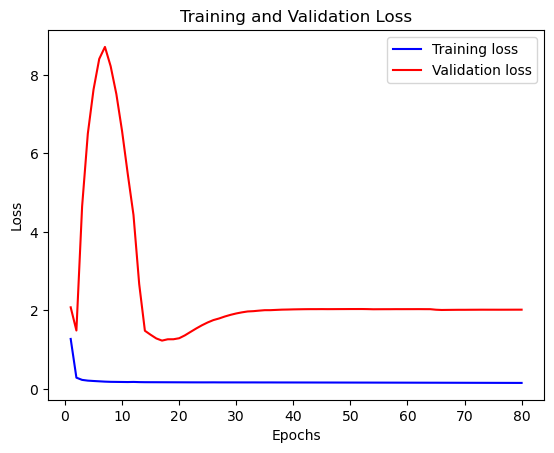

In [70]:
plot_loss(history)

In [61]:
from tensorflow.keras.models import load_model

loaded_model_nonRegress = load_model("/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/cnn_1d_binaryClassifier_10000_1000inds_lr1e3_epoch17_loss1.2294_acc0.9130_20240418_163505.h5")#""/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_noOHE_lr1e3_epoch5_loss0.5344_acc0.8725_20240216_112515.h5")#"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier.h5_epoch4_loss0.7019_acc0.7647_20240214_191738.h5")
loaded_model_nonRegress.summary()

2024-04-19 14:23:22.011131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-19 14:23:22.025942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-19 14:23:22.026081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-19 14:23:22.026381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFl

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 10000, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 9970, 16)          512       
                                                                 
 batch_normalization (BatchN  (None, 9970, 16)         64        
 ormalization)                                                   
                                                                 
 pool1G (MaxPooling1D)       (None, 1661, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 1647, 32)          7712      
                                                                 
 batch_normalization_1 (Batc  (None, 1647, 32)         128       
 hNormalization)                                             

In [62]:
#predictions = loaded_model.predict(X_test)
predictions_binary = convert_preds(X_test,loaded_model_nonRegress)

#print("predictions2 ", predictions_binary.size)
#print("labels", test['PD.x'].values.size)

my_confusion_matrix(y_test,predictions_binary)

2024-04-19 14:23:24.897633: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


3/3 [==============================] - 1s 4ms/step
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]]
Accuracy: 0.9130434782608695
Confusion Matrix:
 [[25  6]
 [ 0 38]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.81      0.89        31
         1.0       0.86      1.00      0.93        38

    accuracy                           0.91        69
   macro avg       0.93      0.90      0.91        69
weighted avg       0.92      0.91      0.91        69



2024-04-19 14:23:25.833235: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


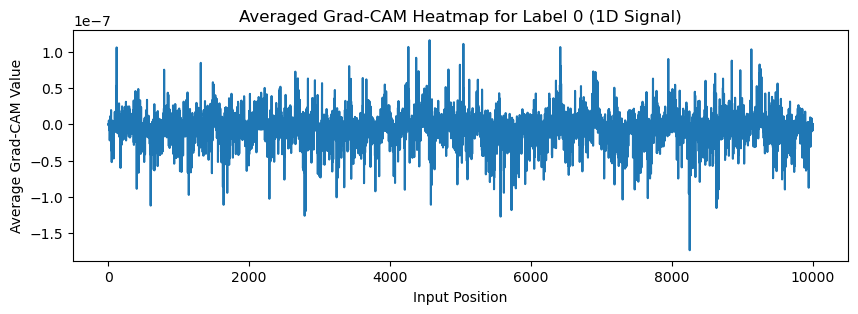

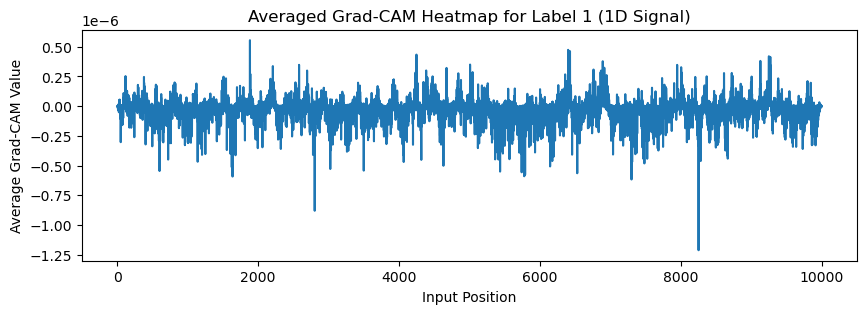

In [73]:
avg_grad_cam_0 = plot_gradCam_average(X_test, y_test, 0, loaded_model_nonRegress)
avg_grad_cam_1 = plot_gradCam_average(X_test,y_test,1,loaded_model_nonRegress)

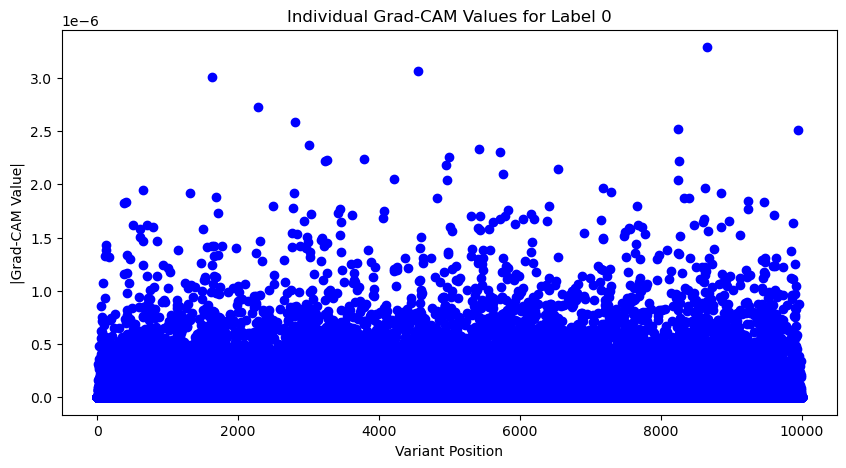

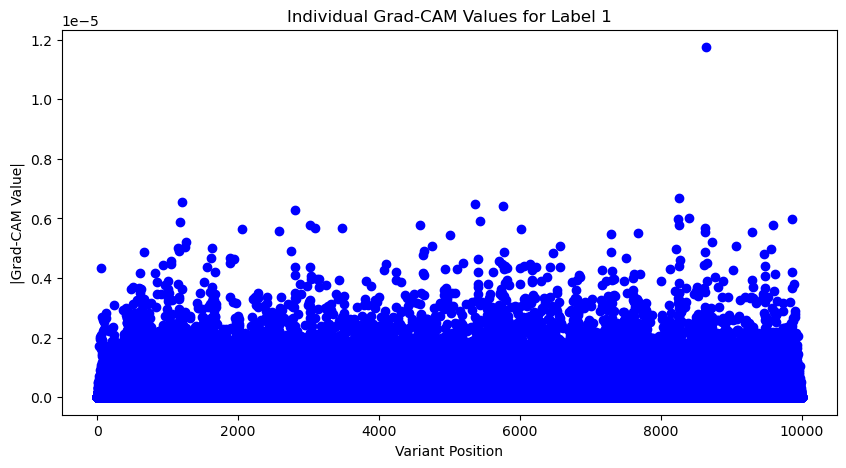

[array([[0.0000000e+00],
        [1.6201909e-09],
        [1.3211235e-09],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.0000000e+00],
        [0.0000000e+00],
        [4.2179904e-10],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.0000000e+00],
        [0.0000000e+00],
        [1.2345974e-09],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.0000000e+00],
        [6.9280737e-10],
        [7.9275315e-09],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.000000e+00],
        [0.000000e+00],
        [8.248032e-10],
        ...,
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00]], dtype=float32),
 array([[0.000000e+00],
        [0.000000e+00],
        [9.586812e-09],
        ...,
        [0.000000e+00

In [74]:
plot_gradCam_individual_scatter(X_test, y_test, 0, loaded_model_nonRegress)
plot_gradCam_individual_scatter(X_test,y_test,1,loaded_model_nonRegress)

In [75]:
print_peaks(geno_df_0, avg_grad_cam_0, threshold = 0.0004)
print_peaks(geno_df_1, avg_grad_cam_1, threshold = 0.002)

4560
[ 0.0000000e+00  0.0000000e+00 -1.2458706e-10 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
Peak Indices: []
VEP:

1885
[ 0.0000000e+00 -7.7298057e-11  4.9291005e-10 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
Peak Indices: []
VEP:



In [76]:
print_top_values(geno_df_0, avg_grad_cam_0, 500)
print_top_values(geno_df_1, avg_grad_cam_1, 500)

Top 500 Indices: [4561 7210 5385 4936 2103 1928 9262 9583 6785 1613 2318 1189 3645 6235
 2323 2756 2234 1038 8558 4562 2964 7152 4935 6130 1207 8939 9605 7640
 8330 2596 7785 7791 3610 9644 3549 8628 4208 1519 5665 9319 9852 6401
 6145  383 3155  733 5965 9728 7973 1859 2971 9610 2517 9861 5864  853
  758 1385 5516 5165 8872 2412  460 7483 7831 2277  925  704 1810 2001
 7330 4461 3920 6179 2489 2468 2248 7243  522  596 7953 6506 1010 3577
 5111 2011 3464 6867 8739 1749 9679 5120 5469 8762 7194 1848 6259 9324
 9918 6068  734 4294 8626 1994 6297 7355 3572 5357 9569 8945 5548  646
 1062 8249 8485 5318 4988 9684 2977 6553 3785 7270 1288 1351 1665 8808
 3251 9129  845 7537 6381 2170 9377 5327 3014 5312 4796 7142 1125 1658
 6897 7968 8625 3926 4585 8597 2335 9473 9254 7639 2504 7130 7374 5136
 8325 5408 2258 5567 5228 4343 3270 5796 3944 6299 6050  970 6368 1011
 2342  386 9633  425 8258 7447 9272 8256 6808 7241 8446 1638 3498 6625
 1769 9851 7781 3308 7102 4317 7543 8110 4576 9900 5749  962

In [96]:
print(y_test)

[0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1.]


[0.]


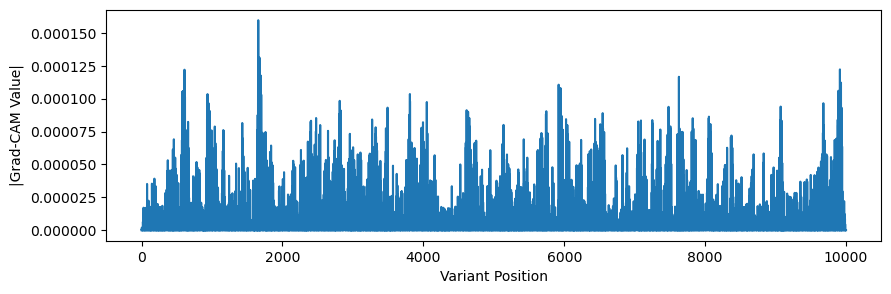

(1, 10000, 1)
(1, 10000, 1)
[[[-0.]
  [ 0.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]]
[1.]


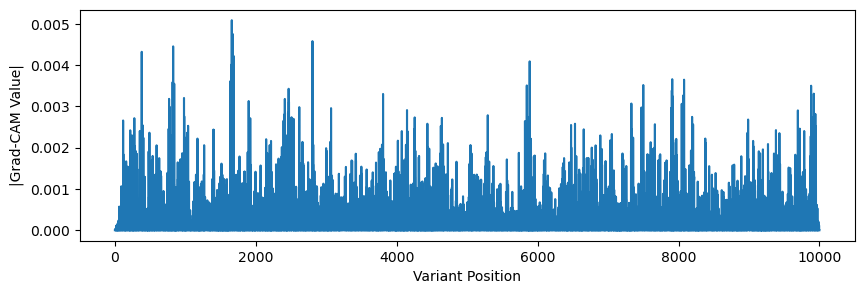

(1, 10000, 1)
(1, 10000, 1)
[[[-0.0000000e+00]
  [-9.1265980e-07]
  [-2.9604498e-06]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]]


array([[[-0.0000000e+00],
        [-9.1265980e-07],
        [-2.9604498e-06],
        ...,
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00]]], dtype=float32)

In [105]:
plot_gradCam(X_test,y_test,0, loaded_model_nonRegress)
plot_gradCam(X_test,y_test,1, loaded_model_nonRegress)

In [63]:
def log_reg_first_layer(X_train, X_test, X_valid, X_train_popStruc, X_test_popStruc, X_valid_popStruc):
    
    # REGRESSION

    # Residuals
    # Initialize empty arrays to store residuals
    resid_train = np.zeros_like(X_train)
    resid_test = np.zeros_like(X_test)
    resid_valid = np.zeros_like(X_valid)

    log_models = []

    snp_variances = np.var(X_train, axis=0)
    # Loop through each feature in the features from flatten layer ie chr 5 flatten layer is 13504
    for i in range(X_train.shape[1]):
        if snp_variances[i] > 0:
            #y = layers.Dense(units=20, activation="linear")(population_structure_input)

            # fit linear model for current feature[i]
            lm = LogisticRegression(multi_class='multinomial',solver='saga', max_iter=10000).fit(X_train_popStruc, X_train[:,i].ravel())

            # Save the linear model
            log_models.append(lm)

            # predict features explained by population structure
            p_train = lm.predict(X_train_popStruc)#train_data_all_r_features[:,i])
            p_test = lm.predict(X_test_popStruc)#test_data_all_r_features[:,i])
            p_valid= lm.predict(X_valid_popStruc)#valid_data_all_r_features[:,i])


            #print(p_train.shape)
            #print(X_train[:,i].shape)
            # calculate residuals 
            resid_train[:, i] =  X_train[:,i] - p_train.reshape(-1, 1)
            resid_test[:, i] =  X_test[:,i] - p_test.reshape(-1, 1)
            resid_valid [:, i]=  X_valid[:,i] - p_valid.reshape(-1, 1)

    return resid_train, resid_test, resid_valid, log_models

In [64]:
print(X_train[:,9])

[[1]
 [1]
 [0]
 [0]
 [1]
 [2]
 [0]
 [2]
 [2]
 [0]
 [2]
 [2]
 [0]
 [2]
 [2]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [0]
 [1]
 [1]
 [1]
 [2]
 [0]
 [1]
 [1]
 [2]
 [1]
 [1]
 [2]
 [1]
 [2]
 [1]
 [2]
 [1]
 [1]
 [2]
 [1]
 [2]
 [2]
 [2]
 [1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [2]
 [0]
 [0]
 [1]
 [1]
 [2]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [2]
 [1]
 [1]
 [2]
 [0]
 [1]
 [1]
 [0]
 [1]
 [2]
 [1]
 [2]
 [2]
 [2]
 [1]
 [1]
 [2]
 [2]
 [1]
 [0]
 [1]
 [1]
 [1]
 [2]
 [1]
 [0]
 [0]
 [2]
 [0]
 [0]
 [2]
 [2]
 [2]
 [1]
 [0]
 [1]
 [2]
 [1]
 [2]
 [2]
 [2]
 [1]
 [2]
 [1]
 [1]
 [2]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [0]
 [2]
 [1]
 [2]
 [1]
 [2]
 [1]
 [1]
 [2]
 [1]
 [2]
 [1]
 [2]
 [1]
 [1]
 [2]
 [2]
 [2]
 [1]
 [1]
 [0]
 [1]
 [2]
 [2]
 [0]
 [2]
 [2]
 [2]
 [1]
 [0]
 [1]
 [1]
 [2]
 [2]
 [1]
 [2]
 [2]
 [2]
 [1]
 [0]
 [2]
 [0]
 [2]
 [1]
 [1]
 [2]
 [1]
 [2]
 [1]
 [0]
 [1]
 [2]
 [1]
 [0]
 [0]
 [2]
 [1]
 [2]
 [0]
 [1]
 [2]
 [2]
 [2]
 [0]
 [0]
 [2]
 [0]
 [1]
 [2]
 [1]
 [0]
 [1]


# Regress out

In [65]:
resid_train, resid_test, resid_valid, log_models = log_reg_first_layer(X_train, X_test, X_valid, X_train_popStruc, X_test_popStruc, X_valid_popStruc)

In [66]:
print(resid_test.shape)

(69, 10000, 1)


In [81]:
save_resids(np.squeeze(resid_train),ids_train,"/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/resid_TRAIN_sim_trait_ids_1000inds.csv")
save_resids(np.squeeze(resid_test),ids_test,"/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/resid_TEST_sim_trait_ids_1000inds.csv")
save_resids(np.squeeze(resid_valid),ids_valid,"/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/resid_VALID_sim_trait_ids_1000inds.csv")


Saved:  /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/resid_TRAIN_sim_trait_ids_1000inds.csv
Saved:  /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/resid_TEST_sim_trait_ids_1000inds.csv
Saved:  /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/resid_VALID_sim_trait_ids_1000inds.csv


# CNN - regressed at input layer

In [82]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [83]:
model = compile_model(num_snps,1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 10000, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 9970, 16)          512       
                                                                 
 batch_normalization_2 (Batc  (None, 9970, 16)         64        
 hNormalization)                                                 
                                                                 
 pool1G (MaxPooling1D)       (None, 1661, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 1647, 32)          7712      
                                                                 
 batch_normalization_3 (Batc  (None, 1647, 32)         128       
 hNormalization)                                           

/home/gdagasso/anaconda3/envs/anomalyDetectionTF/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [84]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/"
model_name = "cnn_1d_binaryClassifier_regressedAtInput_lr1e3"
#model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name
#regressed_model_path = model_file_path + model_regressed

In [85]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 16:43:59


In [86]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{cnn_model_path}_epoch{{epoch}}_loss{{val_loss:.4f}}_acc{{val_accuracy:.4f}}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
                                                         , monitor='val_loss', verbose=2, save_best_only=True, include_optimizer=True, save_weights_only=False, mode='auto',
                                                         save_freq='epoch')

In [89]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitor validation loss
                              factor=0.1,          # Factor by which the learning rate will be reduced
                              patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
                              min_lr=0.00001)      # Lower bound on the learning rate


In [92]:
history = model.fit(resid_train, y_train, batch_size = 12,epochs=80, validation_data=(resid_valid,y_valid),
                    callbacks=[checkpoint_callback,reduce_lr], verbose=2) #lr_callback, checkpoint_callback, lr_callback tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),

Epoch 1/80

Epoch 1: val_loss did not improve from 0.64263
27/27 - 0s - loss: 0.0906 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.6959 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 130ms/epoch - 5ms/step
Epoch 2/80

Epoch 2: val_loss did not improve from 0.64263
27/27 - 0s - loss: 0.0901 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.6976 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 104ms/epoch - 4ms/step
Epoch 3/80

Epoch 3: val_loss did not improve from 0.64263
27/27 - 0s - loss: 0.0897 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.6976 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 105ms/epoch - 4ms/step
Epoch 4/80

Epoch 4: val_loss did not improve from 0.64263
27/27 - 0s - loss: 0.0892 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.6971 - val_accuracy: 0.9130 - val_p

Epoch 32/80

Epoch 32: val_loss did not improve from 0.64263
27/27 - 0s - loss: 0.0761 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7006 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 96ms/epoch - 4ms/step
Epoch 33/80

Epoch 33: val_loss did not improve from 0.64263
27/27 - 0s - loss: 0.0756 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7014 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 104ms/epoch - 4ms/step
Epoch 34/80

Epoch 34: val_loss did not improve from 0.64263
27/27 - 0s - loss: 0.0751 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7010 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 96ms/epoch - 4ms/step
Epoch 35/80

Epoch 35: val_loss did not improve from 0.64263
27/27 - 0s - loss: 0.0747 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.6716 - val_accuracy: 0.9130 -

27/27 - 0s - loss: 0.0617 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7085 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 96ms/epoch - 4ms/step
Epoch 63/80

Epoch 63: val_loss did not improve from 0.64263
27/27 - 0s - loss: 0.0612 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7094 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 99ms/epoch - 4ms/step
Epoch 64/80

Epoch 64: val_loss did not improve from 0.64263
27/27 - 0s - loss: 0.0607 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7095 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 - 103ms/epoch - 4ms/step
Epoch 65/80

Epoch 65: val_loss did not improve from 0.64263
27/27 - 0s - loss: 0.0603 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7086 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - lr: 1.0000e-05 

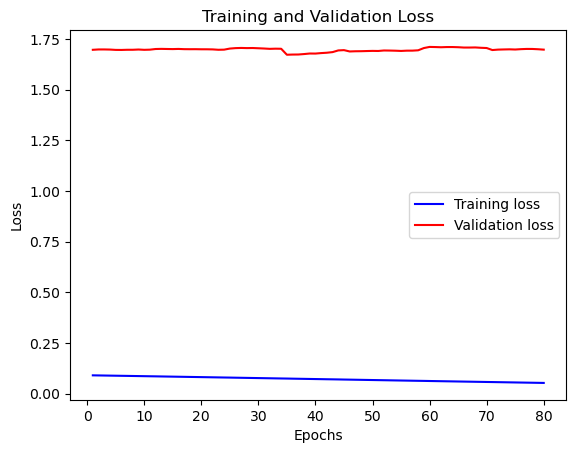

In [93]:
plot_loss(history)

In [141]:
history_dict = history.history

In [67]:
from tensorflow.keras.models import load_model

loaded_model_regress = load_model("/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/cnn_1d_binaryClassifier_regressedAtInput_lr1e3_epoch1_loss0.6426_acc0.8696_20240418_164400.h5")#""/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_noOHE_lr1e3_epoch5_loss0.5344_acc0.8725_20240216_112515.h5")#"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier.h5_epoch4_loss0.7019_acc0.7647_20240214_191738.h5")
loaded_model_regress.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 10000, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 9970, 16)          512       
                                                                 
 batch_normalization_2 (Batc  (None, 9970, 16)         64        
 hNormalization)                                                 
                                                                 
 pool1G (MaxPooling1D)       (None, 1661, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 1647, 32)          7712      
                                                                 
 batch_normalization_3 (Batc  (None, 1647, 32)         128       
 hNormalization)                                           

In [68]:
#predictions = loaded_model.predict(X_test)
predictions_binary = convert_preds(resid_test,loaded_model_regress)

#print("predictions2 ", predictions_binary.size)
#print("labels", test['PD.x'].values.size)

my_confusion_matrix(y_test,predictions_binary)

3/3 [==============================] - 0s 2ms/step
[[0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]]
Accuracy: 0.8405797101449275
Confusion Matrix:
 [[25  6]
 [ 5 33]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.81      0.82        31
         1.0       0.85      0.87      0.86        38

    accuracy                           0.84        69
   macro avg       0.84      0.84      0.84        69
weighted avg       0.84      0.84      0.84        69



In [96]:
print(X_test.shape)
print(y_test[:10])

(69, 10000, 1)
[0. 1. 0. 0. 1. 1. 0. 0. 1. 0.]


[1.]


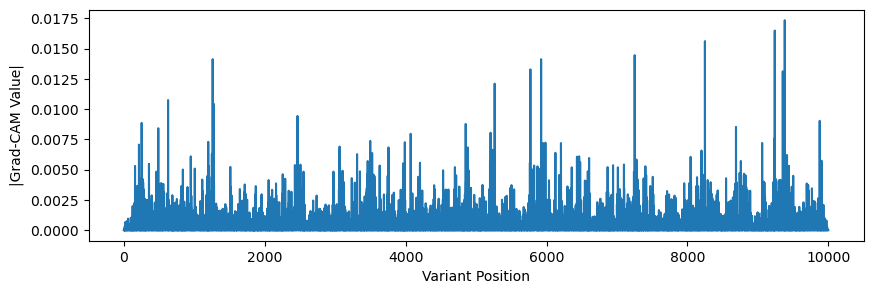

(1, 10000, 1)
(1, 10000, 1)
[[[0.0000000e+00]
  [1.9450683e-05]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]]
[1.]


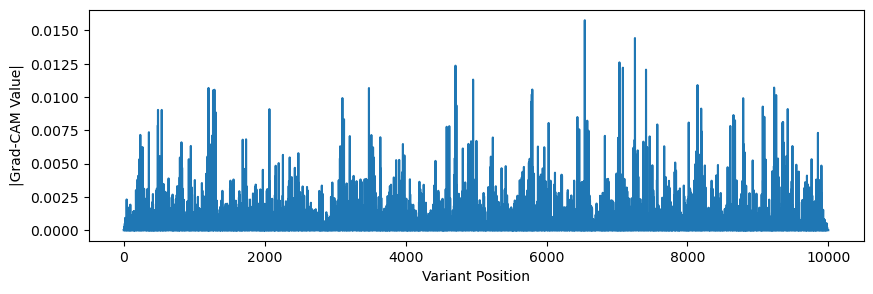

(1, 10000, 1)
(1, 10000, 1)
[[[-0.0000000e+00]
  [ 0.0000000e+00]
  [ 7.3650954e-05]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [-0.0000000e+00]]]
[0.]


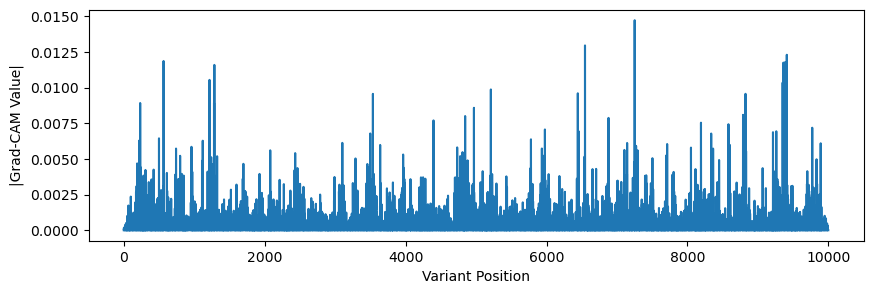

(1, 10000, 1)
(1, 10000, 1)
[[[-0.        ]
  [-0.        ]
  [ 0.00016471]
  ...
  [ 0.        ]
  [ 0.        ]
  [-0.        ]]]
[0.]


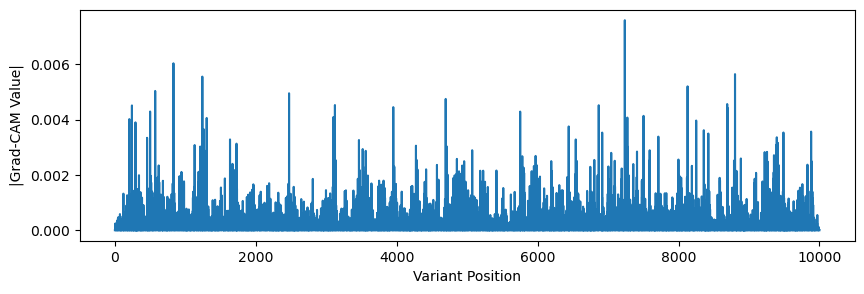

(1, 10000, 1)
(1, 10000, 1)
[[[-0.]
  [ 0.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]]


In [97]:
grad_cam_1 = plot_gradCam(resid_test,y_test,1,loaded_model_regress)
grad_cam_2 = plot_gradCam(resid_test,y_test,4,loaded_model_regress)
grad_cam_3 = plot_gradCam(resid_test,y_test,0,loaded_model_regress)
grad_cam_4 = plot_gradCam(resid_test,y_test,3,loaded_model_regress)

In [146]:
# reshaped_X_resid = np.squeeze(resid_test, axis=2)

In [147]:
# X_resid_df = pd.DataFrame(reshaped_X_resid, columns=df_1.columns, index = ids_test)

NameError: name 'df_1' is not defined

In [148]:
print_peaks(geno_df_0, grad_cam_4, threshold = 0.005)

332
[-0.  0.  0. ...  0.  0.  0.]
Peak Indices: []
VEP:



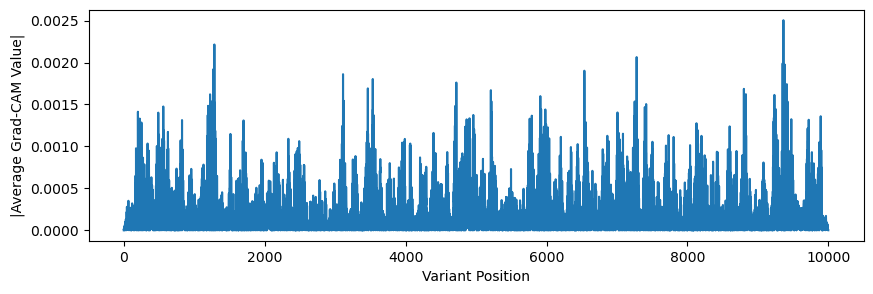

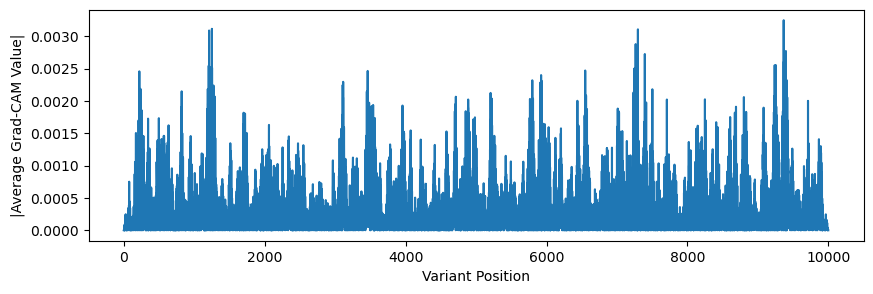

In [98]:
avg_grad_cam_0 = plot_gradCam_average_manPlot(resid_test, y_test, 0, loaded_model_regress)
avg_grad_cam_1 = plot_gradCam_average_manPlot(resid_test,y_test,1,loaded_model_regress)

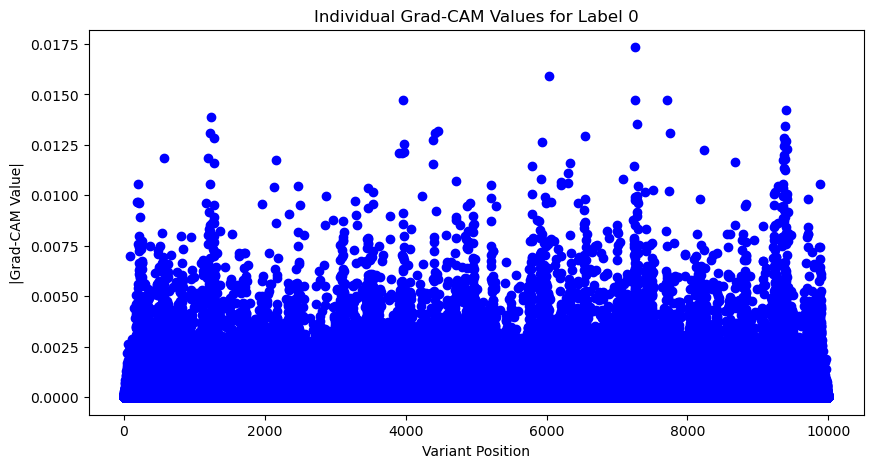

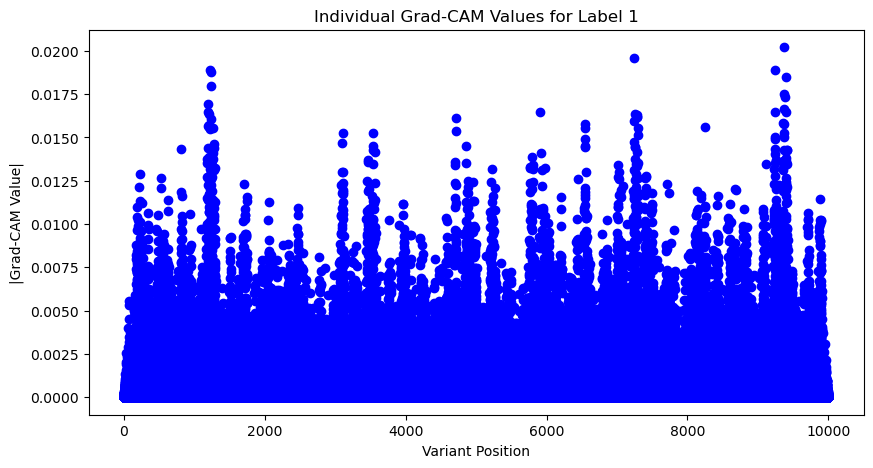

[array([[0.0000000e+00],
        [1.9450683e-05],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.0000000e+00],
        [0.0000000e+00],
        [7.3650954e-05],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.0000000e+00],
        [0.0000000e+00],
        [2.1536649e-05],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.000000e+00],
        [2.643128e-07],
        [4.370372e-05],
        ...,
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[0.0000000e+00],
        [0.0000000e+00],
        [1.6841059e-05],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=fl

In [99]:
plot_gradCam_individual_scatter(resid_test, y_test, 0, loaded_model_regress)
plot_gradCam_individual_scatter(resid_test,y_test,1,loaded_model_regress)


In [100]:
print_top_values(geno_df_0, avg_grad_cam_0, 500)
print_top_values(geno_df_1, avg_grad_cam_1, 500)

Top 500 Indices: [5268 8153 6802  258 7003 2167 8815 8172  528 9893 7243 2561 2339 8784
 4598 9377 5938 2557 2505  564 7266 7418 5215 7088 1132 9419 3439  460
  292  261  806 5940 4218  809 5097 3451 9218 2472 1972 7811 9278 3501
 9792 9692  257 5787 3775 3141 1207 8250 7689 7712 8786 8794 4071 1968
 6029 2131 9236 8808 4967 9079 7485 6033 4775 6581 6450 6851 9728 1957
 7709  520 6876 5241 9701 7294 7411 1267 8364 6562  238 1696 3538 3526
 7152  259  252 3985 5898  342 7284 5905 9284 3944 6444 9270 1961 7069
 3477  235 2461 8180 5749 5971 7013 4879 3070 8258 8822 8176 1954  265
 3251 9268 8593 5752 9369 7237 5739 5226 3641 9352 7065 1235 9888 7497
 3102 9696 5098 4403 5957 1733 3558 9723 6557 9252 4891 6534 8252 4797
 6449  273 4893 1282 4205 4819 9395 2338 3974 5227 6011  220 4973 6437
 7144 2340 4876 9396 9221 1210 3289 7397  515 1248 9890 6008 4699 4708
 1218 6188 9495 6547 1190 8244  215 8781 8136 4070 8131 6998  823  242
 4845 8690 8183 4880 2498 3119 4897 7491 3453 2435 6541 7262

In [151]:
print_peaks(geno_df_0, avg_grad_cam_0, threshold = 0.004)
print_peaks(geno_df_0, avg_grad_cam_1, threshold = 0.01)

338
[ 0.0000000e+00  2.6045500e-08 -1.0053757e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
Peak Indices: [ 331  336  338  352  931 1683 4539 4665 6105 7234 7761 9797]
Peak Index: 331
Column Name: 332
Grad-CAM Value: 0.0046844655
Peak Index: 336
Column Name: 337
Grad-CAM Value: 0.0061137555
Peak Index: 338
Column Name: 339
Grad-CAM Value: 0.0062454278
Peak Index: 352
Column Name: 353
Grad-CAM Value: 0.0044316505
Peak Index: 931
Column Name: 932
Grad-CAM Value: 0.0044927215
Peak Index: 1683
Column Name: 1684
Grad-CAM Value: 0.0041867606
Peak Index: 4539
Column Name: 4540
Grad-CAM Value: 0.004044658
Peak Index: 4665
Column Name: 4666
Grad-CAM Value: 0.0041300813
Peak Index: 6105
Column Name: 6106
Grad-CAM Value: 0.004883781
Peak Index: 7234
Column Name: 7235
Grad-CAM Value: 0.004777254
Peak Index: 7761
Column Name: 7762
Grad-CAM Value: 0.0048051807
Peak Index: 9797
Column Name: 9798
Grad-CAM Value: 0.0040144725
VEP:

332
337
339
353
932
1684
4540
4666
6106
7235
7762
9798
2428
[ 

[0.]


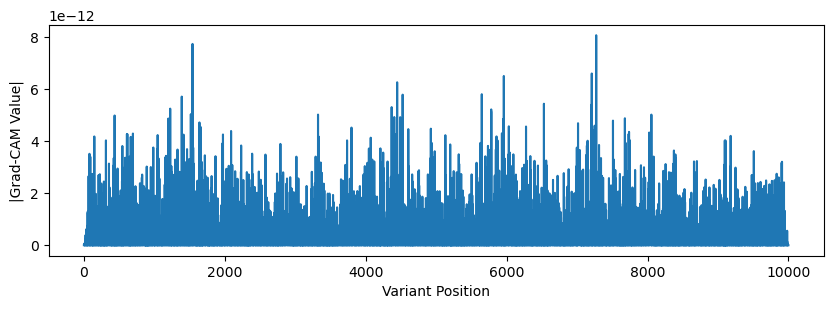

(1, 10000, 1)
(1, 10000, 1)
[[[-0.]
  [-0.]
  [-0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]]
[0.]


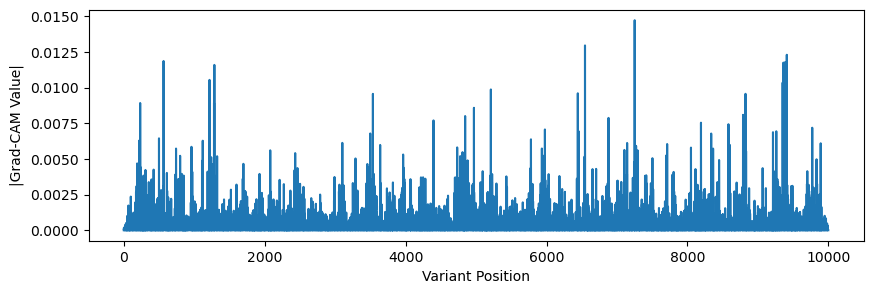

(1, 10000, 1)
(1, 10000, 1)
[[[-0.        ]
  [-0.        ]
  [ 0.00016471]
  ...
  [ 0.        ]
  [ 0.        ]
  [-0.        ]]]
[1.]


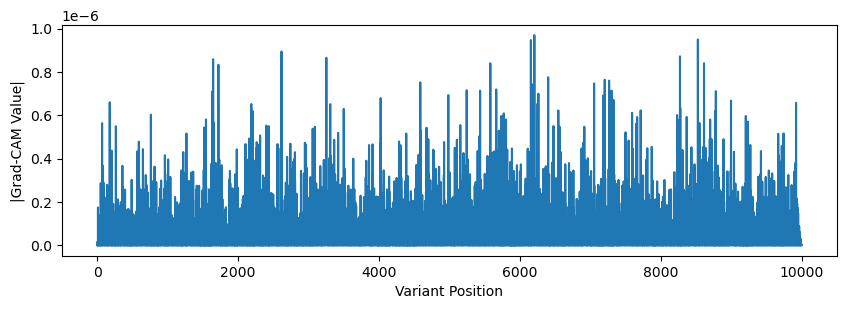

(1, 10000, 1)
(1, 10000, 1)
[[[ 0.0000000e+00]
  [-1.6201909e-09]
  [-1.3211235e-09]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]]
[1.]


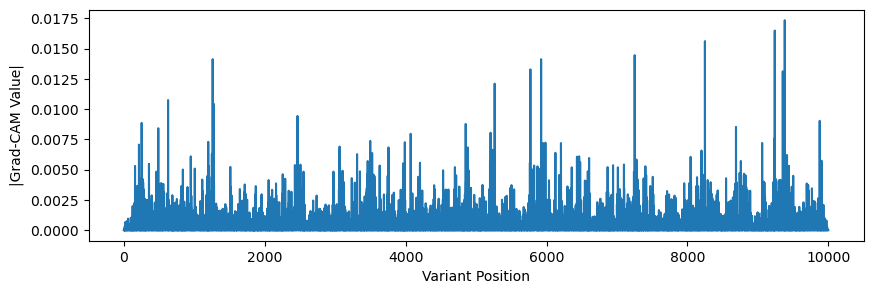

(1, 10000, 1)
(1, 10000, 1)
[[[0.0000000e+00]
  [1.9450683e-05]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]]


array([[[0.0000000e+00],
        [1.9450683e-05],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]]], dtype=float32)

In [101]:
plot_gradCam(X_test,y_test,0, loaded_model_nonRegress)
plot_gradCam(resid_test,y_test,0, loaded_model_regress)
plot_gradCam(X_test,y_test,1, loaded_model_nonRegress)
plot_gradCam(resid_test,y_test,1, loaded_model_regress)

In [102]:
print(y_test)

[0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1.]


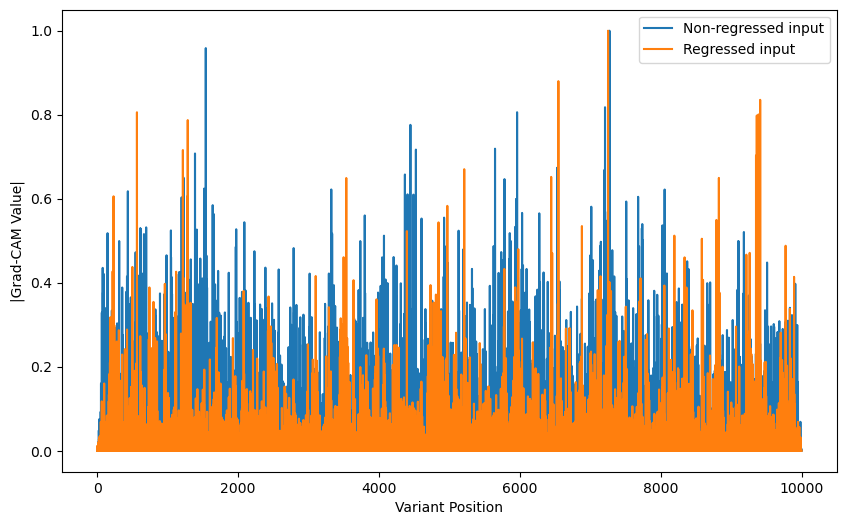

(array([[[-0.],
         [-0.],
         [-0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]]], dtype=float32),
 array([[[-0.        ],
         [-0.        ],
         [ 0.00016471],
         ...,
         [ 0.        ],
         [ 0.        ],
         [-0.        ]]], dtype=float32))

In [103]:
plot_gradCam_ind_overlay(X_test, resid_test, y_test, 0, loaded_model_nonRegress, loaded_model_regress)

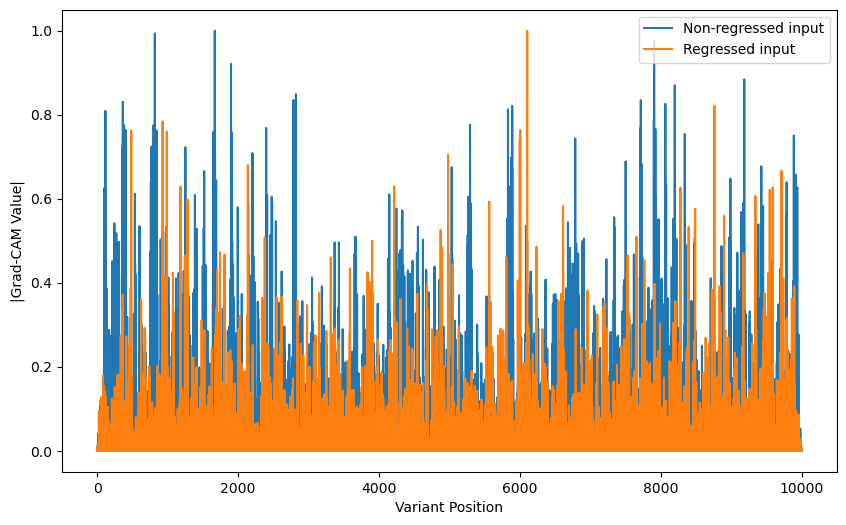

(array([[[-0.0000000e+00],
         [-0.0000000e+00],
         [ 2.6465868e-06],
         ...,
         [ 0.0000000e+00],
         [ 0.0000000e+00],
         [ 0.0000000e+00]]], dtype=float32),
 array([[[-0.        ],
         [-0.        ],
         [-0.00167124],
         ...,
         [ 0.        ],
         [-0.        ],
         [ 0.        ]]], dtype=float32))

In [123]:
plot_gradCam_ind_overlay(X_test, resid_test, y_test, 5, loaded_model_nonRegress, loaded_model_regress)

# FROM FLATTEN LAYER ANALYSES

In [64]:
from tensorflow.keras.models import load_model

#loaded_model_non_regressed = load_model("/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/cnn_1d_binaryClassifier_10000_1000inds_lr1e3_epoch2_loss0.5639_acc0.8841_20240403_135559.h5")#""/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_noOHE_lr1e3_epoch5_loss0.5344_acc0.8725_20240216_112515.h5")#"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier.h5_epoch4_loss0.7019_acc0.7647_20240214_191738.h5")
loaded_model_nonRegress.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 10000, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 9970, 16)          512       
                                                                 
 batch_normalization (BatchN  (None, 9970, 16)         64        
 ormalization)                                                   
                                                                 
 pool1G (MaxPooling1D)       (None, 1661, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 1647, 32)          7712      
                                                                 
 batch_normalization_1 (Batc  (None, 1647, 32)         128       
 hNormalization)                                             

# Intermediate Model 

In [ ]:
inter_model = intermediate_model("flatten",loaded_model_nonRegress)

In [ ]:
train_data_features = get_outputs(inter_model,X_train)
test_data_features = get_outputs(inter_model, X_test)
valid_data_features = get_outputs(inter_model, X_valid)

In [ ]:
flatten_feature_size  = train_data_features.shape[1]
print(flatten_feature_size)

In [ ]:
# non regressed 

In [70]:
binary_predictor_model = binary_predictor_model_noOHE(flatten_feature_size)

Model: "binary_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17568)]           0         
                                                                 
 dense (Dense)               (None, 512)               8995328   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,159,681
Trainable params: 9,159,68

/home/gdagasso/anaconda3/envs/anomalyDetectionTF/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [71]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/simulatedTraits_popSruc/Models/"
model_name = "cnn_1d_binaryClassifier_nonregressedAtflatten_lr1e3"
#model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name

#regressed_model_path = model_file_path + model_regressed
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{cnn_model_path}_epoch{{epoch}}_loss{{val_loss:.4f}}_acc{{val_accuracy:.4f}}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
                                                         , monitor='val_loss', verbose=2, save_best_only=True, include_optimizer=True, save_weights_only=False, mode='auto',
                                                         save_freq='epoch')

Current Time = 17:52:32


In [72]:
history = binary_predictor_model.fit(
    train_data_features,
    y_train,
    validation_data=(valid_data_features,y_valid),
    epochs=80,
    batch_size=10,
    shuffle=False,
    verbose =2,
    callbacks=[checkpoint_callback]
)

Epoch 1/80


2024-04-18 17:52:35.506271: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 1: val_loss improved from inf to 0.32274, saving model to /media/gdagasso/TOSHIBA EXT/simulatedTraits_popSruc/Models/cnn_1d_binaryClassifier_nonregressedAtflatten_lr1e3_epoch1_loss0.3227_acc0.9130_20240418_175232.h5
33/33 - 1s - loss: 0.4038 - accuracy: 0.8882 - precision: 0.9264 - recall: 0.8629 - val_loss: 0.3227 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - 582ms/epoch - 18ms/step
Epoch 2/80

Epoch 2: val_loss improved from 0.32274 to 0.29067, saving model to /media/gdagasso/TOSHIBA EXT/simulatedTraits_popSruc/Models/cnn_1d_binaryClassifier_nonregressedAtflatten_lr1e3_epoch2_loss0.2907_acc0.9130_20240418_175232.h5
33/33 - 0s - loss: 0.1697 - accuracy: 0.9596 - precision: 0.9309 - recall: 1.0000 - val_loss: 0.2907 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - 187ms/epoch - 6ms/step
Epoch 3/80

Epoch 3: val_loss improved from 0.29067 to 0.28905, saving model to /media/gdagasso/TOSHIBA EXT/simulatedTraits_popSruc/Models/cnn_1d_bina

Epoch 32/80

Epoch 32: val_loss did not improve from 0.28905
33/33 - 0s - loss: 0.0014 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5749 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - 64ms/epoch - 2ms/step
Epoch 33/80

Epoch 33: val_loss did not improve from 0.28905
33/33 - 0s - loss: 0.0012 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5788 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - 65ms/epoch - 2ms/step
Epoch 34/80

Epoch 34: val_loss did not improve from 0.28905
33/33 - 0s - loss: 0.0016 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5805 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - 64ms/epoch - 2ms/step
Epoch 35/80

Epoch 35: val_loss did not improve from 0.28905
33/33 - 0s - loss: 0.0012 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5894 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - 65ms/e

Epoch 64/80

Epoch 64: val_loss did not improve from 0.28905
33/33 - 0s - loss: 3.4591e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7106 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - 65ms/epoch - 2ms/step
Epoch 65/80

Epoch 65: val_loss did not improve from 0.28905
33/33 - 0s - loss: 3.6042e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7152 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - 64ms/epoch - 2ms/step
Epoch 66/80

Epoch 66: val_loss did not improve from 0.28905
33/33 - 0s - loss: 2.2674e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7183 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall: 1.0000 - 70ms/epoch - 2ms/step
Epoch 67/80

Epoch 67: val_loss did not improve from 0.28905
33/33 - 0s - loss: 2.4827e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7206 - val_accuracy: 0.9130 - val_precision: 0.8605 - val_recall:

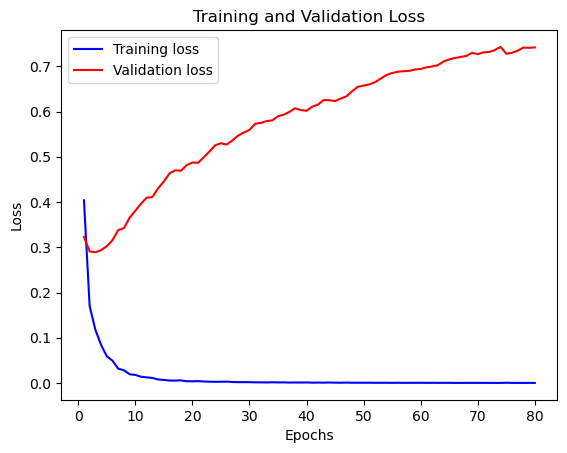

In [75]:
plot_loss(history)

In [ ]:
from tensorflow.keras.models import load_model

loaded_model_flatten_nonRegress = load_model("/media/gdagasso/TOSHIBA EXT/simulatedTraits_popSruc/Models/cnn_1d_binaryClassifier_nonregressedAtflatten_lr1e3_epoch3_loss0.2891_acc0.9130_20240418_175232.h5")#""/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_noOHE_lr1e3_epoch5_loss0.5344_acc0.8725_20240216_112515.h5")#"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier.h5_epoch4_loss0.7019_acc0.7647_20240214_191738.h5")
loaded_model_flatten_nonRegress.summary()

In [ ]:
#predictions = loaded_model.predict(X_test)
predictions_binary = convert_preds(test_data_features,loaded_model_flatten_nonRegress)

#print("predictions2 ", predictions_binary.size)
#print("labels", test['PD.x'].values.size)

my_confusion_matrix(y_test,predictions_binary)

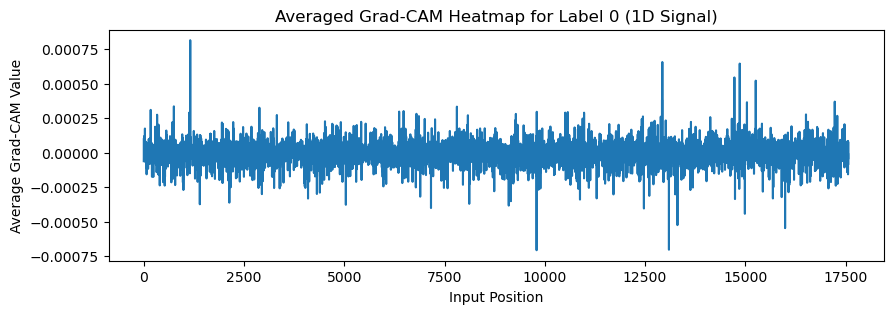

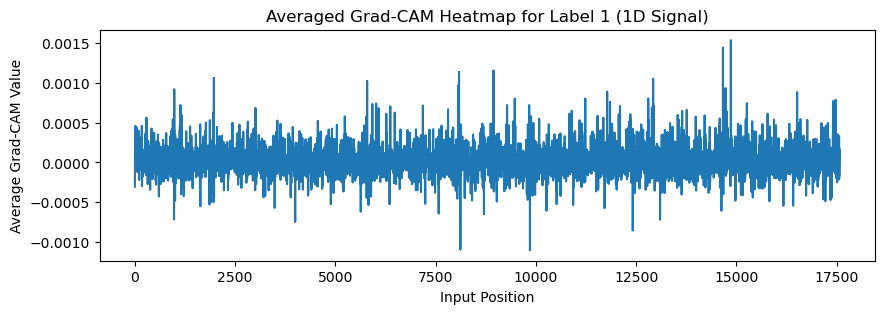

In [78]:
avg_grad_cam_0 = plot_gradCam_average(test_data_features, y_test, 0, loaded_model_flatten_nonRegress)
avg_grad_cam_1 = plot_gradCam_average(test_data_features,y_test,1,loaded_model_flatten_nonRegress)

# Residualise

In [ ]:
from sklearn.linear_model import LinearRegression
# REGRESSION

# Residuals
# Initialize empty arrays to store residuals
resid_train = np.zeros_like(train_data_features)
resid_test = np.zeros_like(test_data_features)
resid_valid = np.zeros_like(valid_data_features)


# Loop through each feature in the features from flatten layer ie chr 5 flatten layer is 13504
for i in range(train_data_features.shape[1]):
    #y = layers.Dense(units=20, activation="linear")(population_structure_input)
    
    # fit linear model for current feature[i]
    lm = LinearRegression().fit(X_train_popStruc, train_data_features[:,i])
    
    # predict features explained by population structure
    p_train = lm.predict(X_train_popStruc)#train_data_all_r_features[:,i])
    p_test = lm.predict(X_test_popStruc)#test_data_all_r_features[:,i])
    p_valid= lm.predict(X_valid_popStruc)#valid_data_all_r_features[:,i])
    
    
    # calculate residuals 
    resid_train[:, i] =  train_data_features[:,i] - p_train
    resid_test[:, i] =  test_data_features[:,i] - p_test
    resid_valid [:, i]=  valid_data_features[:,i] - p_valid
    

In [ ]:
print(resid_train.shape)
flatten_feature_size = resid_train.shape[1]

# Binary Predictor Model 

In [84]:
binary_predictor_model = binary_predictor_model_noOHE(flatten_feature_size)

Model: "binary_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 17568)]           0         
                                                                 
 dense_4 (Dense)             (None, 512)               8995328   
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,159,681
Trainable params: 9,159,68

/home/gdagasso/anaconda3/envs/anomalyDetectionTF/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [85]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/"
model_name = "cnn_1d_binaryClassifier_regressedAtflatten_lr1e3"
#model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name

#regressed_model_path = model_file_path + model_regressed
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{cnn_model_path}_epoch{{epoch}}_loss{{val_loss:.4f}}_acc{{val_accuracy:.4f}}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
                                                         , monitor='val_loss', verbose=2, save_best_only=True, include_optimizer=True, save_weights_only=False, mode='auto',
                                                         save_freq='epoch')

Current Time = 17:56:18


In [88]:
history = binary_predictor_model.fit(
    resid_train,
    y_train,
    validation_data=(resid_valid,y_valid),
    epochs=80,
    batch_size=8,
    shuffle=False,
    verbose =2,
    callbacks=[checkpoint_callback]
)

Epoch 1/80

Epoch 1: val_loss did not improve from 0.69083
41/41 - 0s - loss: 0.0041 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6964 - val_accuracy: 0.5217 - val_precision: 0.5476 - val_recall: 0.6216 - 98ms/epoch - 2ms/step
Epoch 2/80

Epoch 2: val_loss did not improve from 0.69083
41/41 - 0s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6966 - val_accuracy: 0.5217 - val_precision: 0.5476 - val_recall: 0.6216 - 78ms/epoch - 2ms/step
Epoch 3/80

Epoch 3: val_loss did not improve from 0.69083
41/41 - 0s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6969 - val_accuracy: 0.5217 - val_precision: 0.5476 - val_recall: 0.6216 - 78ms/epoch - 2ms/step
Epoch 4/80

Epoch 4: val_loss did not improve from 0.69083
41/41 - 0s - loss: 0.0034 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6972 - val_accuracy: 0.5217 - val_precision: 0.5476 - val_recall: 0.6216 - 78ms/epoch - 2

Epoch 34/80

Epoch 34: val_loss did not improve from 0.69083
41/41 - 0s - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7052 - val_accuracy: 0.5217 - val_precision: 0.5476 - val_recall: 0.6216 - 76ms/epoch - 2ms/step
Epoch 35/80

Epoch 35: val_loss did not improve from 0.69083
41/41 - 0s - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7053 - val_accuracy: 0.5362 - val_precision: 0.5610 - val_recall: 0.6216 - 75ms/epoch - 2ms/step
Epoch 36/80

Epoch 36: val_loss did not improve from 0.69083
41/41 - 0s - loss: 0.0010 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7054 - val_accuracy: 0.5362 - val_precision: 0.5610 - val_recall: 0.6216 - 75ms/epoch - 2ms/step
Epoch 37/80

Epoch 37: val_loss did not improve from 0.69083
41/41 - 0s - loss: 9.2365e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7059 - val_accuracy: 0.5362 - val_precision: 0.5610 - val_recall: 0.6216 - 74

Epoch 66/80

Epoch 66: val_loss did not improve from 0.69083
41/41 - 0s - loss: 4.0228e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7141 - val_accuracy: 0.5507 - val_precision: 0.5714 - val_recall: 0.6486 - 77ms/epoch - 2ms/step
Epoch 67/80

Epoch 67: val_loss did not improve from 0.69083
41/41 - 0s - loss: 3.8616e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7144 - val_accuracy: 0.5507 - val_precision: 0.5714 - val_recall: 0.6486 - 78ms/epoch - 2ms/step
Epoch 68/80

Epoch 68: val_loss did not improve from 0.69083
41/41 - 0s - loss: 3.9333e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7149 - val_accuracy: 0.5652 - val_precision: 0.5814 - val_recall: 0.6757 - 81ms/epoch - 2ms/step
Epoch 69/80

Epoch 69: val_loss did not improve from 0.69083
41/41 - 0s - loss: 3.7942e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7151 - val_accuracy: 0.5652 - val_precision: 0.5814 - val_recall:

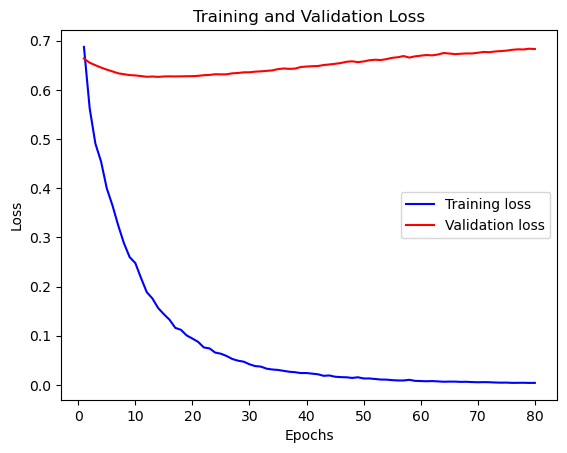

In [177]:
plot_loss(history)

In [ ]:
from tensorflow.keras.models import load_model

loaded_model_flatten_regress = load_model("/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_regressedAtflatten_lr1e3_epoch80_loss0.4599_acc0.7826_20240403_162222.h5")#""/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_noOHE_lr1e3_epoch5_loss0.5344_acc0.8725_20240216_112515.h5")#"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier.h5_epoch4_loss0.7019_acc0.7647_20240214_191738.h5")
loaded_model_flatten_regress.summary()

In [ ]:
#predictions = loaded_model.predict(X_test)
predictions_binary = convert_preds(resid_test,loaded_model_flatten_regress)

#print("predictions2 ", predictions_binary.size)
#print("labels", test['PD.x'].values.size)

my_confusion_matrix(y_test,predictions_binary)

In [ ]:
print(y_test)

In [ ]:
plot_gradCam_ind_overlay(test_data_features, resid_test, y_test, 0, loaded_model_flatten_nonRegress, loaded_model_flatten_regress)

In [ ]:
plot_gradCam_ind_overlay(test_data_features, resid_test, y_test, 5, loaded_model_flatten_regress, loaded_model_flatten_nonRegress)

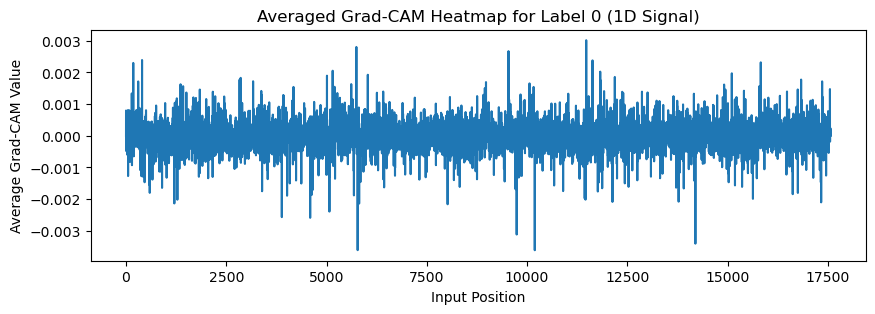

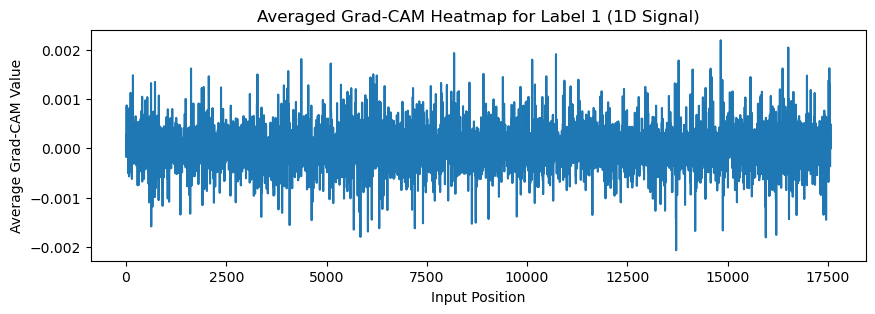

In [180]:
avg_grad_cam_0 = plot_gradCam_average(resid_test, y_test, 0, loaded_model)
avg_grad_cam_1 = plot_gradCam_average(resid_test,y_test,1,loaded_model)

In [ ]:
print_peaks(geno_df_0, avg_grad_cam_0, threshold = 0.004)
print_peaks(geno_df_0, avg_grad_cam_1, threshold = 0.01)